In [2]:
# 1. DATA LOADING & PREPROCESSING -----------------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📁 Dataset path
DATASET_PATH = '/kaggle/input/x-ray-datasets/chest_Xray'
IMG_SIZE = (128, 128)
INPUT_SHAPE = IMG_SIZE + (1,)
BATCH_SIZE = 32

# 📂 Ensure output dir
os.makedirs("results", exist_ok=True)

print("\n📦 Initialisation du générateur de données...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("\n📥 Chargement des datasets...")

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # car on a que 0 ou 1 class_mode='categorical' si plus
    subset='training',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)
validation_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

print("\n✅ Données chargées :")
print(f" - Entraînement : {train_generator.samples} images")
print(f" - Validation   : {validation_generator.samples} images")
print(f" - Test         : {test_generator.samples} images")
print(f" - Classes      : {train_generator.class_indices}\n")
def count_images_by_class(directory_path):
    class_counts = {}
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            count = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[class_name] = count
    return class_counts
print("📊 Détail des images par classe :")
for subset_name, subset_dir in [('Train', 'train'), ('Validation', 'val'), ('Test', 'test')]:
    subset_path = os.path.join(DATASET_PATH, subset_dir)
    class_counts = count_images_by_class(subset_path)
    print(f" - 📂 {subset_name} set :")
    for cls, cnt in class_counts.items():
        print(f"    > {cls}: {cnt} images")
    print()    


📦 Initialisation du générateur de données...

📥 Chargement des datasets...
Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

✅ Données chargées :
 - Entraînement : 4695 images
 - Validation   : 521 images
 - Test         : 624 images
 - Classes      : {'NORMAL': 0, 'PNEUMONIA': 1}

📊 Détail des images par classe :
 - 📂 Train set :
    > PNEUMONIA: 3875 images
    > NORMAL: 1341 images

 - 📂 Validation set :
    > PNEUMONIA: 8 images
    > NORMAL: 8 images

 - 📂 Test set :
    > PNEUMONIA: 390 images
    > NORMAL: 234 images



In [11]:
# 2. MODEL DEFINITION & TRAINING ------------------------------------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np


print("📐 Définition du modèle CNN...")

# model = Sequential([
#     # Input(shape=INPUT_SHAPE),
    
#     # Conv2D(16, (3,3), activation='relu', padding='same'),
#     # BatchNormalization(),
#     # MaxPooling2D((2,2), padding='same'),

#     # Conv2D(32, (3,3), activation='relu', padding='same'),
#     # BatchNormalization(),
#     # MaxPooling2D((2,2), padding='same'),

#     # Conv2D(64, (3,3), activation='relu', padding='same'),
#     # Dropout(0.2),
#     # BatchNormalization(),
#     # MaxPooling2D((2,2), padding='same'),

#     # Conv2D(128, (3,3), activation='relu', padding='same'),
#     # Dropout(0.3),
#     # BatchNormalization(),
#     # MaxPooling2D((2,2), padding='same'),

#     # GlobalAveragePooling2D(),
#     # Dense(128, activation='relu'),
#     # Dropout(0.5),
#     # Dense(1, activation='sigmoid')
#     Input(shape=INPUT_SHAPE),
#     Conv2D(16, (3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2,2)),
#     Conv2D(32, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     Dropout(0.2),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
#     # Flatten(),
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = INPUT_SHAPE))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

print("\n⚙️ Compilation du modèle...")
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

print("\n🛑 Configuration du EarlyStopping...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print("\n💾 Configuration du ModelCheckpoint...")
checkpoint_cb = ModelCheckpoint(
    filepath="results/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,# true if need the .h5
    verbose=1
)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("\n📏 Poids calculés pour les classes :", class_weights_dict)

print("\n🚀 Entraînement du modèle en cours...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint_cb],
    class_weight=class_weights_dict,
    verbose=1
)

print("\n📤 Sauvegarde du modèle...")
model.save('results/pneumonia_cnn_model.h5')
print("\n📤 Saved")


📐 Définition du modèle CNN...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │              

 Total params: 951,489 (3.63 MB)

 Trainable params: 950,401 (3.63 MB)

 Non-trainable params: 1,088 (4.25 KB)


⚙️ Compilation du modèle...

🛑 Configuration du EarlyStopping...

💾 Configuration du ModelCheckpoint...

📏 Poids calculés pour les classes : {0: 1.9449047224523612, 1: 0.6730217889908257}

🚀 Entraînement du modèle en cours...
Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8305 - loss: 0.5404
Epoch 1: val_loss improved from inf to 3.47607, saving model to results/best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8308 - loss: 0.5392 - val_accuracy: 0.7428 - val_loss: 3.4761
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9193 - loss: 0.2035
Epoch 2: val_loss did not improve from 3.47607
147/147 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9193 - loss: 0.2036 - val_accuracy: 0.7428 - val_loss: 4.0897
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9210 - loss: 0.1869
Epoch 3: val_loss did not improve from 3.47607
147/147 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9210 - loss: 0.1868 - val_accuracy: 0.7428 


📊 Évaluation sur le jeu de test...
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.8173 - loss: 0.4732
🎯 Test Accuracy: 0.8734 | Loss: 0.3219

📈 Génération des prédictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step


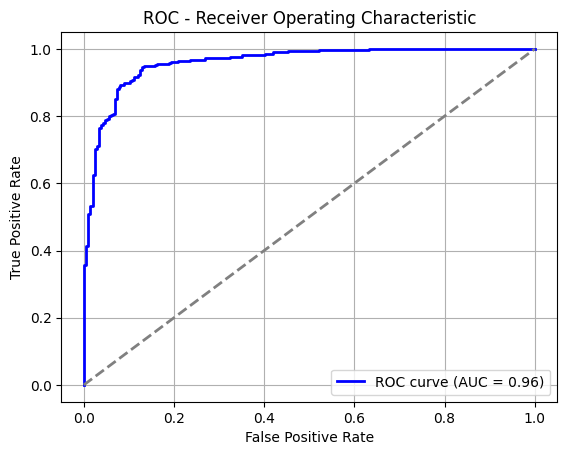

📌 AUC: 0.9613


In [12]:
# 3. EVALUATION & ROC ------------------------------------------------------------------------

print("\n📊 Évaluation sur le jeu de test...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"🎯 Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}\n")

print("📈 Génération des prédictions...")
y_pred = model.predict(test_generator)
y_true = test_generator.classes

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("📌 AUC: {:.4f}".format(roc_auc))


🧾 Rapport de classification à seuil 0.5
              precision    recall  f1-score   support

      Normal       0.94      0.71      0.81       234
   Pneumonia       0.85      0.97      0.91       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



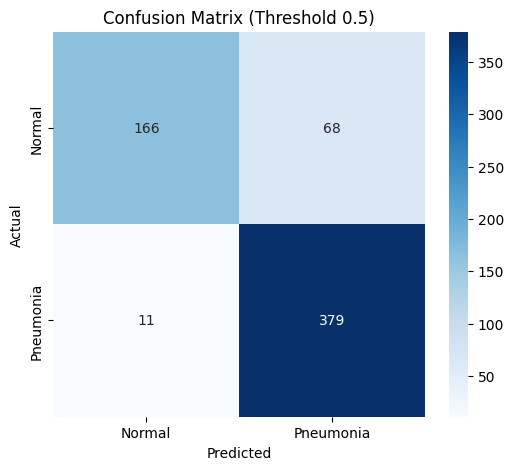

In [13]:
# 4. CONFUSION MATRIX & CLASSIFICATION REPORT -----------------------------------------------

from sklearn.metrics import classification_report

print("\n🧾 Rapport de classification à seuil 0.5")
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Threshold 0.5)')
plt.show()



🔍 Analyse multi-seuils : précision, rappel, F1-score

➡️ Seuil = 0.1
              precision    recall  f1-score   support

      Normal       1.00      0.35      0.52       234
   Pneumonia       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.86      0.68      0.68       624
weighted avg       0.83      0.76      0.72       624



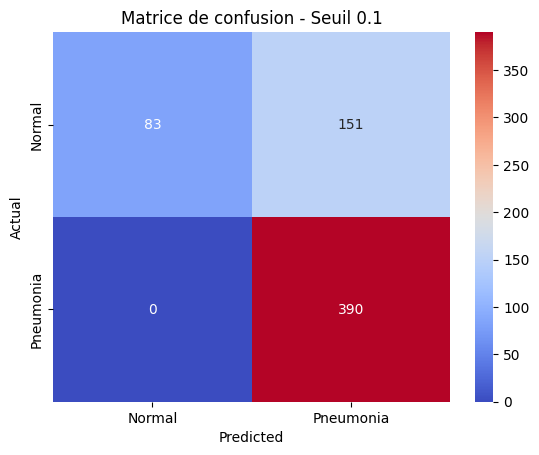


➡️ Seuil = 0.2
              precision    recall  f1-score   support

      Normal       0.99      0.48      0.65       234
   Pneumonia       0.76      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.88      0.74      0.75       624
weighted avg       0.85      0.80      0.78       624



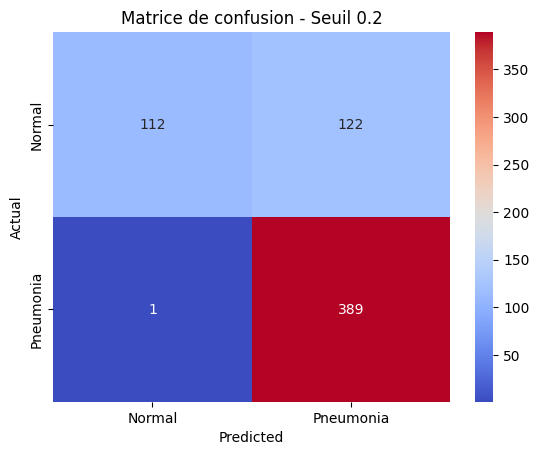


➡️ Seuil = 0.3
              precision    recall  f1-score   support

      Normal       0.98      0.57      0.72       234
   Pneumonia       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



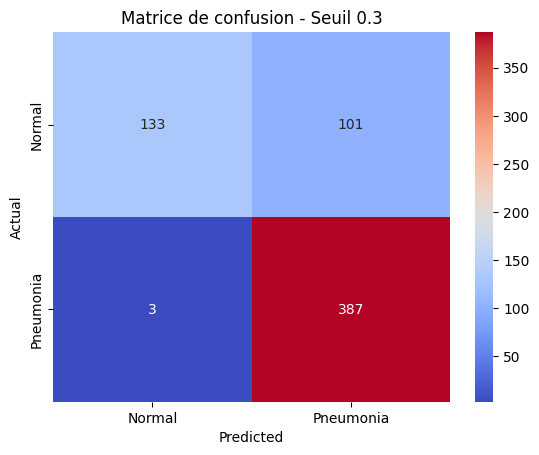


➡️ Seuil = 0.4
              precision    recall  f1-score   support

      Normal       0.96      0.65      0.77       234
   Pneumonia       0.82      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.83       624
weighted avg       0.87      0.86      0.85       624



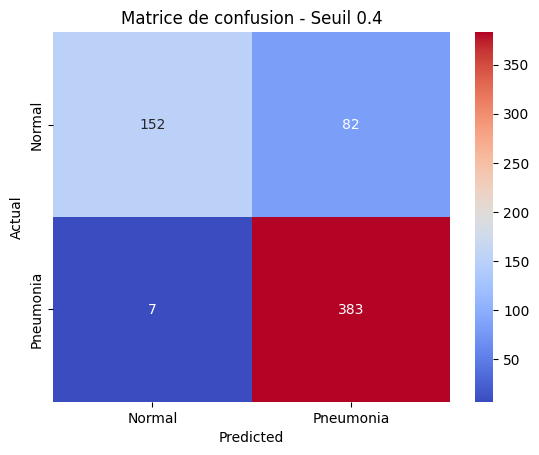


➡️ Seuil = 0.5
              precision    recall  f1-score   support

      Normal       0.94      0.71      0.81       234
   Pneumonia       0.85      0.97      0.91       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



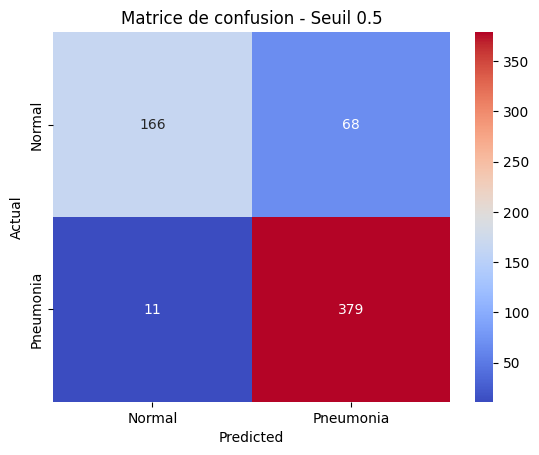


➡️ Seuil = 0.6
              precision    recall  f1-score   support

      Normal       0.93      0.74      0.82       234
   Pneumonia       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



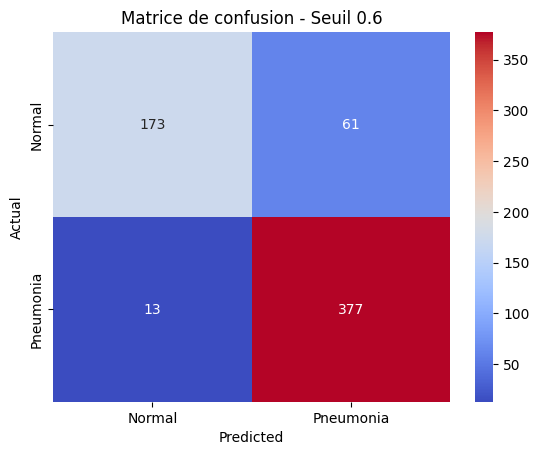


➡️ Seuil = 0.7
              precision    recall  f1-score   support

      Normal       0.93      0.79      0.86       234
   Pneumonia       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



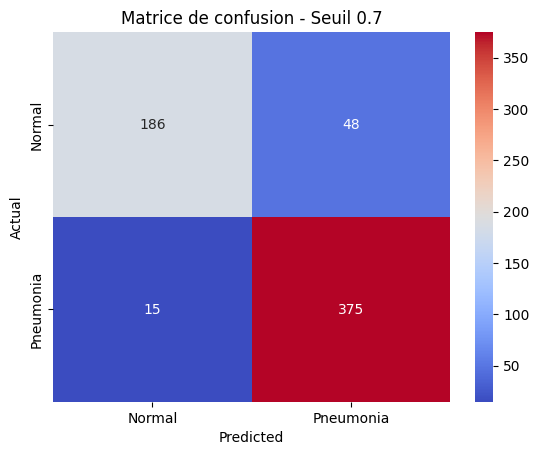


➡️ Seuil = 0.8
              precision    recall  f1-score   support

      Normal       0.91      0.85      0.88       234
   Pneumonia       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



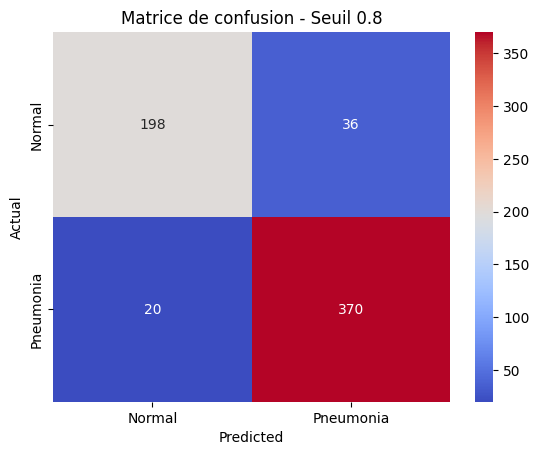


➡️ Seuil = 0.9
              precision    recall  f1-score   support

      Normal       0.84      0.90      0.87       234
   Pneumonia       0.94      0.90      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



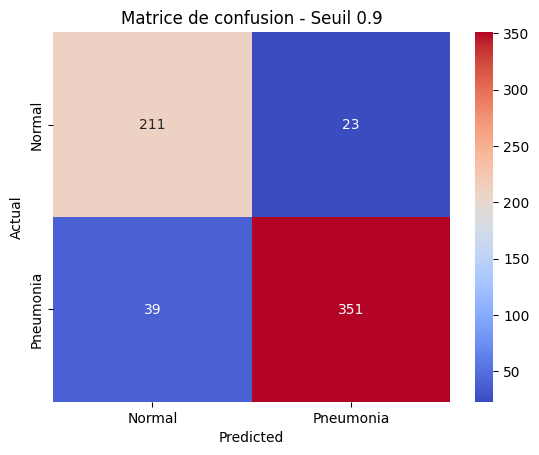

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


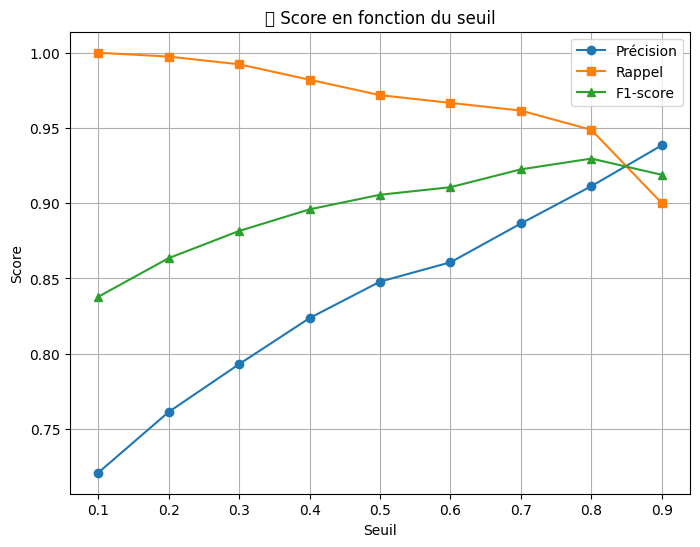

In [14]:
# 5. THRESHOLD ANALYSIS ----------------------------------------------------------------------

print("\n🔍 Analyse multi-seuils : précision, rappel, F1-score")
thresholds = [0.1 * i for i in range(1, 10)]
precisions, recalls, f1_scores = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_pred > thresh).astype(int)
    precision = precision_score(y_true, y_pred_thresh)
    recall = recall_score(y_true, y_pred_thresh)
    f1 = f1_score(y_true, y_pred_thresh)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    print(f"\n➡️ Seuil = {thresh:.1f}")
    print(classification_report(y_true, y_pred_thresh, target_names=['Normal', 'Pneumonia']))
    cm = confusion_matrix(y_true, y_pred_thresh)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Matrice de confusion - Seuil {thresh:.1f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, marker='o', label='Précision')
plt.plot(thresholds, recalls, marker='s', label='Rappel')
plt.plot(thresholds, f1_scores, marker='^', label='F1-score')
plt.title('🎯 Score en fonction du seuil')
plt.xlabel('Seuil')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()
